In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=16,family='serif')
import matplotlib.gridspec as gridspec
from emcee import EnsembleSampler
from emcee.backends import HDFBackend
from multiprocessing import cpu_count, Pool
from corner import corner
from Cosmology import *
import sys


#load autoreload, which automatically reloads the cosmology.py upon execution
%load_ext autoreload
%autoreload 1
%aimport Cosmology


#Parameters for BAO -- CHECK THESE VALUES
z_d = 1089
h = .7
omega_baryon_preset = 0.022765/h**2
omega_gamma_preset = 2.469E-5/h**2

#Cosmological parameters
Omega_m_preset = 0.3089
Omega_r_preset = 2.469E-5/h**2
Omega_c_preset = 0.6911

# Import data

## Supernova data

In [2]:
dataSN = np.loadtxt('data/jla_lcparams.txt', usecols=(2,4,6,8,10))
errSN = np.loadtxt('data/jla_lcparams.txt', usecols=(5,7,9))[np.argsort(dataSN.T[0])]
dataSN = dataSN[np.argsort(dataSN.T[0])]

#best fit values found in JLA analysis arXiv:1401.4064
a = 0.14
b = 3.14
MB = -19.04
delta_Mhost = -.06

In [3]:
SNdata = Supernova_data(dataSN, errSN, np.array([a,b,MB, 0]))

## Quasar data

In [4]:
dataQ = np.loadtxt('data/quasar_data_RL.txt', usecols=(0,1,2,3,4))
errQ = np.loadtxt('data/quasar_data_RL.txt', usecols=5)[np.argsort(dataQ.T[0])]
dataQ = dataQ[np.argsort(dataQ.T[0])]

#best fit values found in Risaliti & Lusso, Nature Astronomy, 2018
beta_prime, s = 7.4, 1.5

In [5]:
Qdata = Quasar_data(dataQ, errQ, np.array([beta_prime, s]))

## BAO data

In [6]:
dataBAO = np.loadtxt('data/bao_1806-06781.txt', usecols=(1,3))
errBAO = np.loadtxt('data/bao_1806-06781.txt', usecols=(4,5))
typeBAO = np.genfromtxt('data/bao_1806-06781.txt',dtype=str, usecols=2)

In [7]:
BAOdata = BAO_data(dataBAO, errBAO, np.array([omega_baryon_preset, omega_gamma_preset]), typeBAO)
LCDM = cosmology(Omega_m_preset, Omega_r_preset, Omega_c_preset, -1, 70)

In [8]:
#calculate sound horizon r_s in MPc in comoving coords
# -- that is the maximum distance an acoustic wave can travel up to at time of decoupling
# depends weakly on omega_b, omega_gamma, and the cosmology
BAOdata.com_sound_horizon(z_d,LCDM)

160.0100275301661

# Set up and run the MCMC sampler [arXiv:1202.3665]

## Define the likelihood and priors

In [9]:
def lnlike(theta, SNdata, Qdata, BAOdata):
    if len(theta) == 9:
        Omegam, Omegac, w, a, b, MB, delta_Mhost, beta_prime, s = theta
        cosmo = cosmology(Omegam, Omega_r_preset, Omegac, w)
    elif len(theta) == 8:
        Omegam, Omegac, a, b, MB, delta_Mhost, beta_prime, s = theta
        cosmo = cosmology(Omegam, Omega_r_preset, Omegac)
    
    SNdata.set_param(np.array([a,b,MB, delta_Mhost]))
    Qdata.set_param(np.array([beta_prime, s]))
    
    log_prob = cosmo.log_likelihood(SNdata)
    log_prob += cosmo.log_likelihood(Qdata)
    log_prob += cosmo.log_likelihood(BAOdata)
    
    if np.isnan(log_prob):
        return -np.inf
    
    
    return log_prob


def lnprior(theta):
    #flat priors:
    if len(theta) == 9:
        Omegam, Omegac, w, a, b, MB, delta_Mhost, beta_prime, s = theta
        if 0 < Omegam < 1.0 and 0 < Omegac < 1.5 and -3 < w < -1/3. and -5 <= a < 5 and -10 < b < 10 and -25 < MB < 0 and -0.5 < delta_Mhost < 0.5 and 0 < beta_prime < 10 and 0 < s <= 3:
            return 0.0
        else:
            return -np.inf
    elif len(theta) == 8:
        Omegam, Omegac, a, b, MB, delta_Mhost, beta_prime, s = theta
        if 0 < Omegam < 1.0 and 0 < Omegac < 1.5 and -3 < w < -1/3. and -5 <= a < 5 and -10 < b < 10 and -25 < MB < 0 and -0.5 < delta_Mhost < 0.5 and 0 < beta_prime < 10 and 0 < s <= 3:
            return 0.0
        else:
            return -np.inf
    else:
        raise TypeError('Position vector has wrong format!')

def lnprob(theta, SNdata, Qdata, BAOdata):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, SNdata, Qdata, BAOdata)

## set up and run the MC sampler locally...
## (uncomment this cell if you want to load a preexisting chain)

In [10]:
ndim, nwalkers, nsteps = 9, 20, 100
pos0 = [np.array([Omega_m_preset, Omega_c_preset, -1, a, b, MB, 0, beta_prime, s]) + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #, .2, 2, .1, -20]])

pool = Pool(cpu_count())
write = HDFBackend('results/LCDM_' + str(nwalkers) + 'x' + str(nsteps) + '.h5')
sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=(SNdata, Qdata, BAOdata), pool=pool)#, backend=write)


tau, accepted = [], []

# Now we'll sample for up to nsteps steps
for i, sample in enumerate(sampler.sample(pos0, iterations=nsteps, progress=True)):
    # Only check convergence every 10 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau.append(np.mean(sampler.get_autocorr_time(tol=0)))
    accepted.append(np.mean(sampler.acceptance_fraction))
pool.close()

100%|██████████| 100/100 [11:57<00:00,  7.21s/it]


# Load $\Lambda$LCDM data

In [11]:
LCDM_sampler = HDFBackend('results/LCDM_500x1000.h5', read_only=True)

nsteps, nwalkers, ndim = LCDM_sampler.get_chain().shape
labs = [r'$\Omega_m$', r'$\Omega_\Lambda$', r'$\alpha$', r'$\beta$', r'$M_B$', r'$\Delta M_B$', r'$\beta^\prime$', r'$\delta$']

## Check and visualise the convergence: $\tau_f / n_\mathrm{steps} < 1/30$

In [12]:
Nmin = 0
while Nmin < nsteps and np.all(LCDM_sampler.get_autocorr_time(tol=0,discard=Nmin)/(nsteps)*30 > 1):
    Nmin+=100
    
print('Nmin = {}'.format(Nmin))

Nmin = 500


<IPython.core.display.Javascript object>


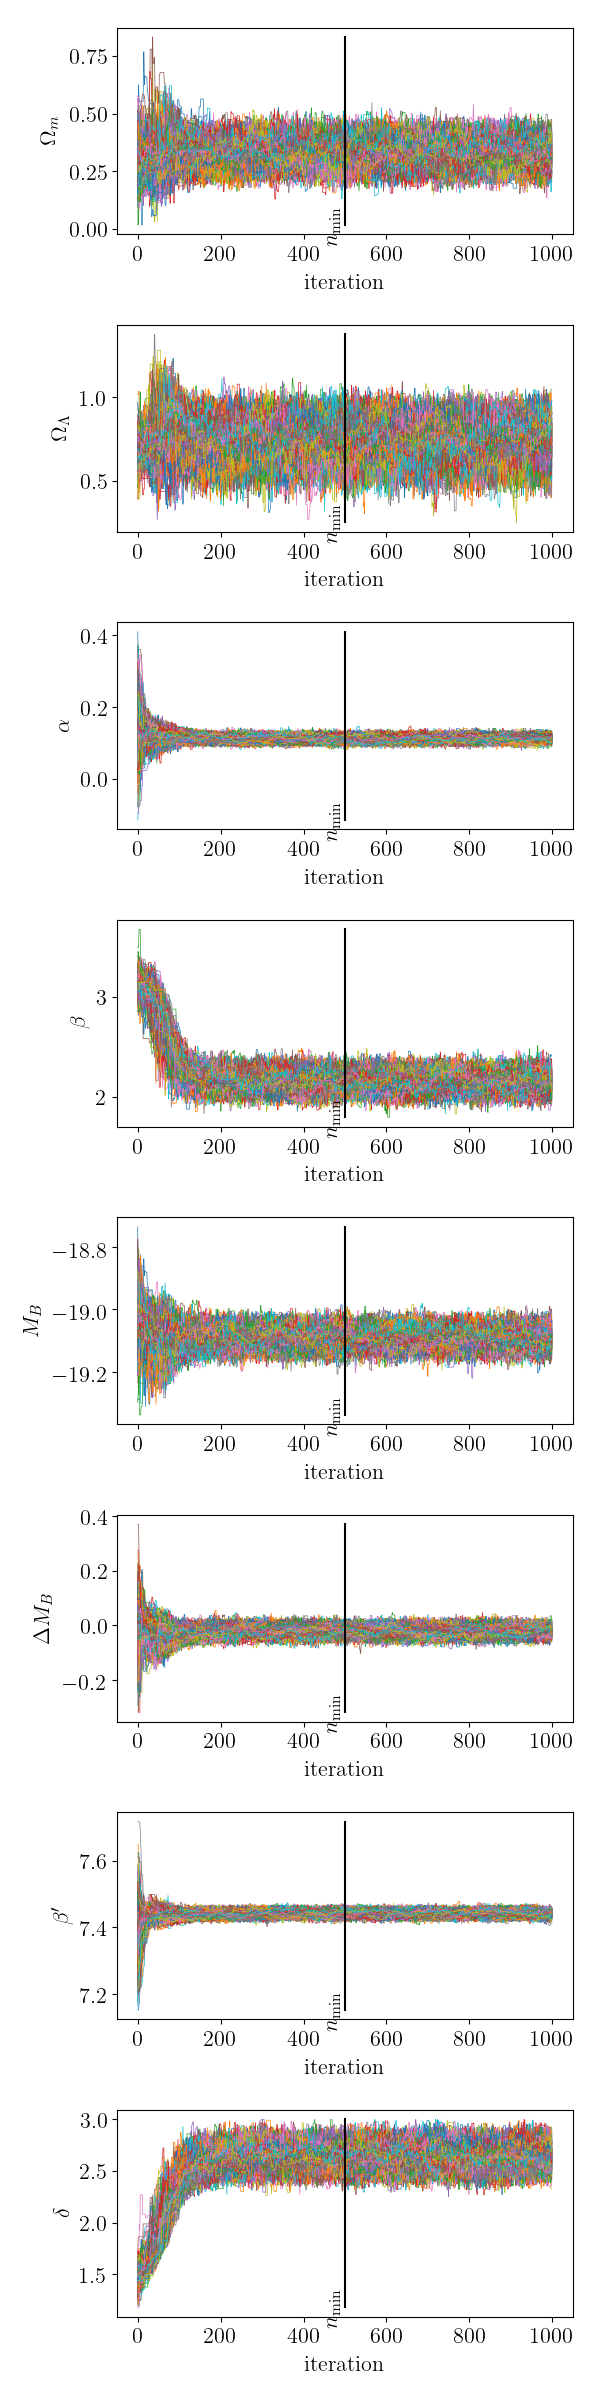

In [13]:
LCDM_samples = LCDM_sampler.get_chain()

f, ax = plt.subplots(len(LCDM_samples.T), 1, figsize=(6,3*len(LCDM_samples.T)))

for i in range(len(LCDM_samples.T)):
    ax[i].plot(LCDM_samples.T[i].T, lw=0.5)
    ax[i].plot([Nmin, Nmin], [min(LCDM_samples.T[i].flatten()), max(LCDM_samples.T[i].flatten())], c='k', lw=1.5)
    ax[i].text(Nmin, min(LCDM_samples.T[i].flatten()), r'$n_\mathrm{min}$', rotation=90, ha='right')
    ax[i].set_ylabel(labs[i])
    ax[i].set_xlabel('iteration')
    
    
plt.tight_layout()
# plt.savefig('plots/convergence_LCDM.pdf')
plt.show()

## Plot the 1$\sigma$ and 2$\sigma$ contours

<IPython.core.display.Javascript object>


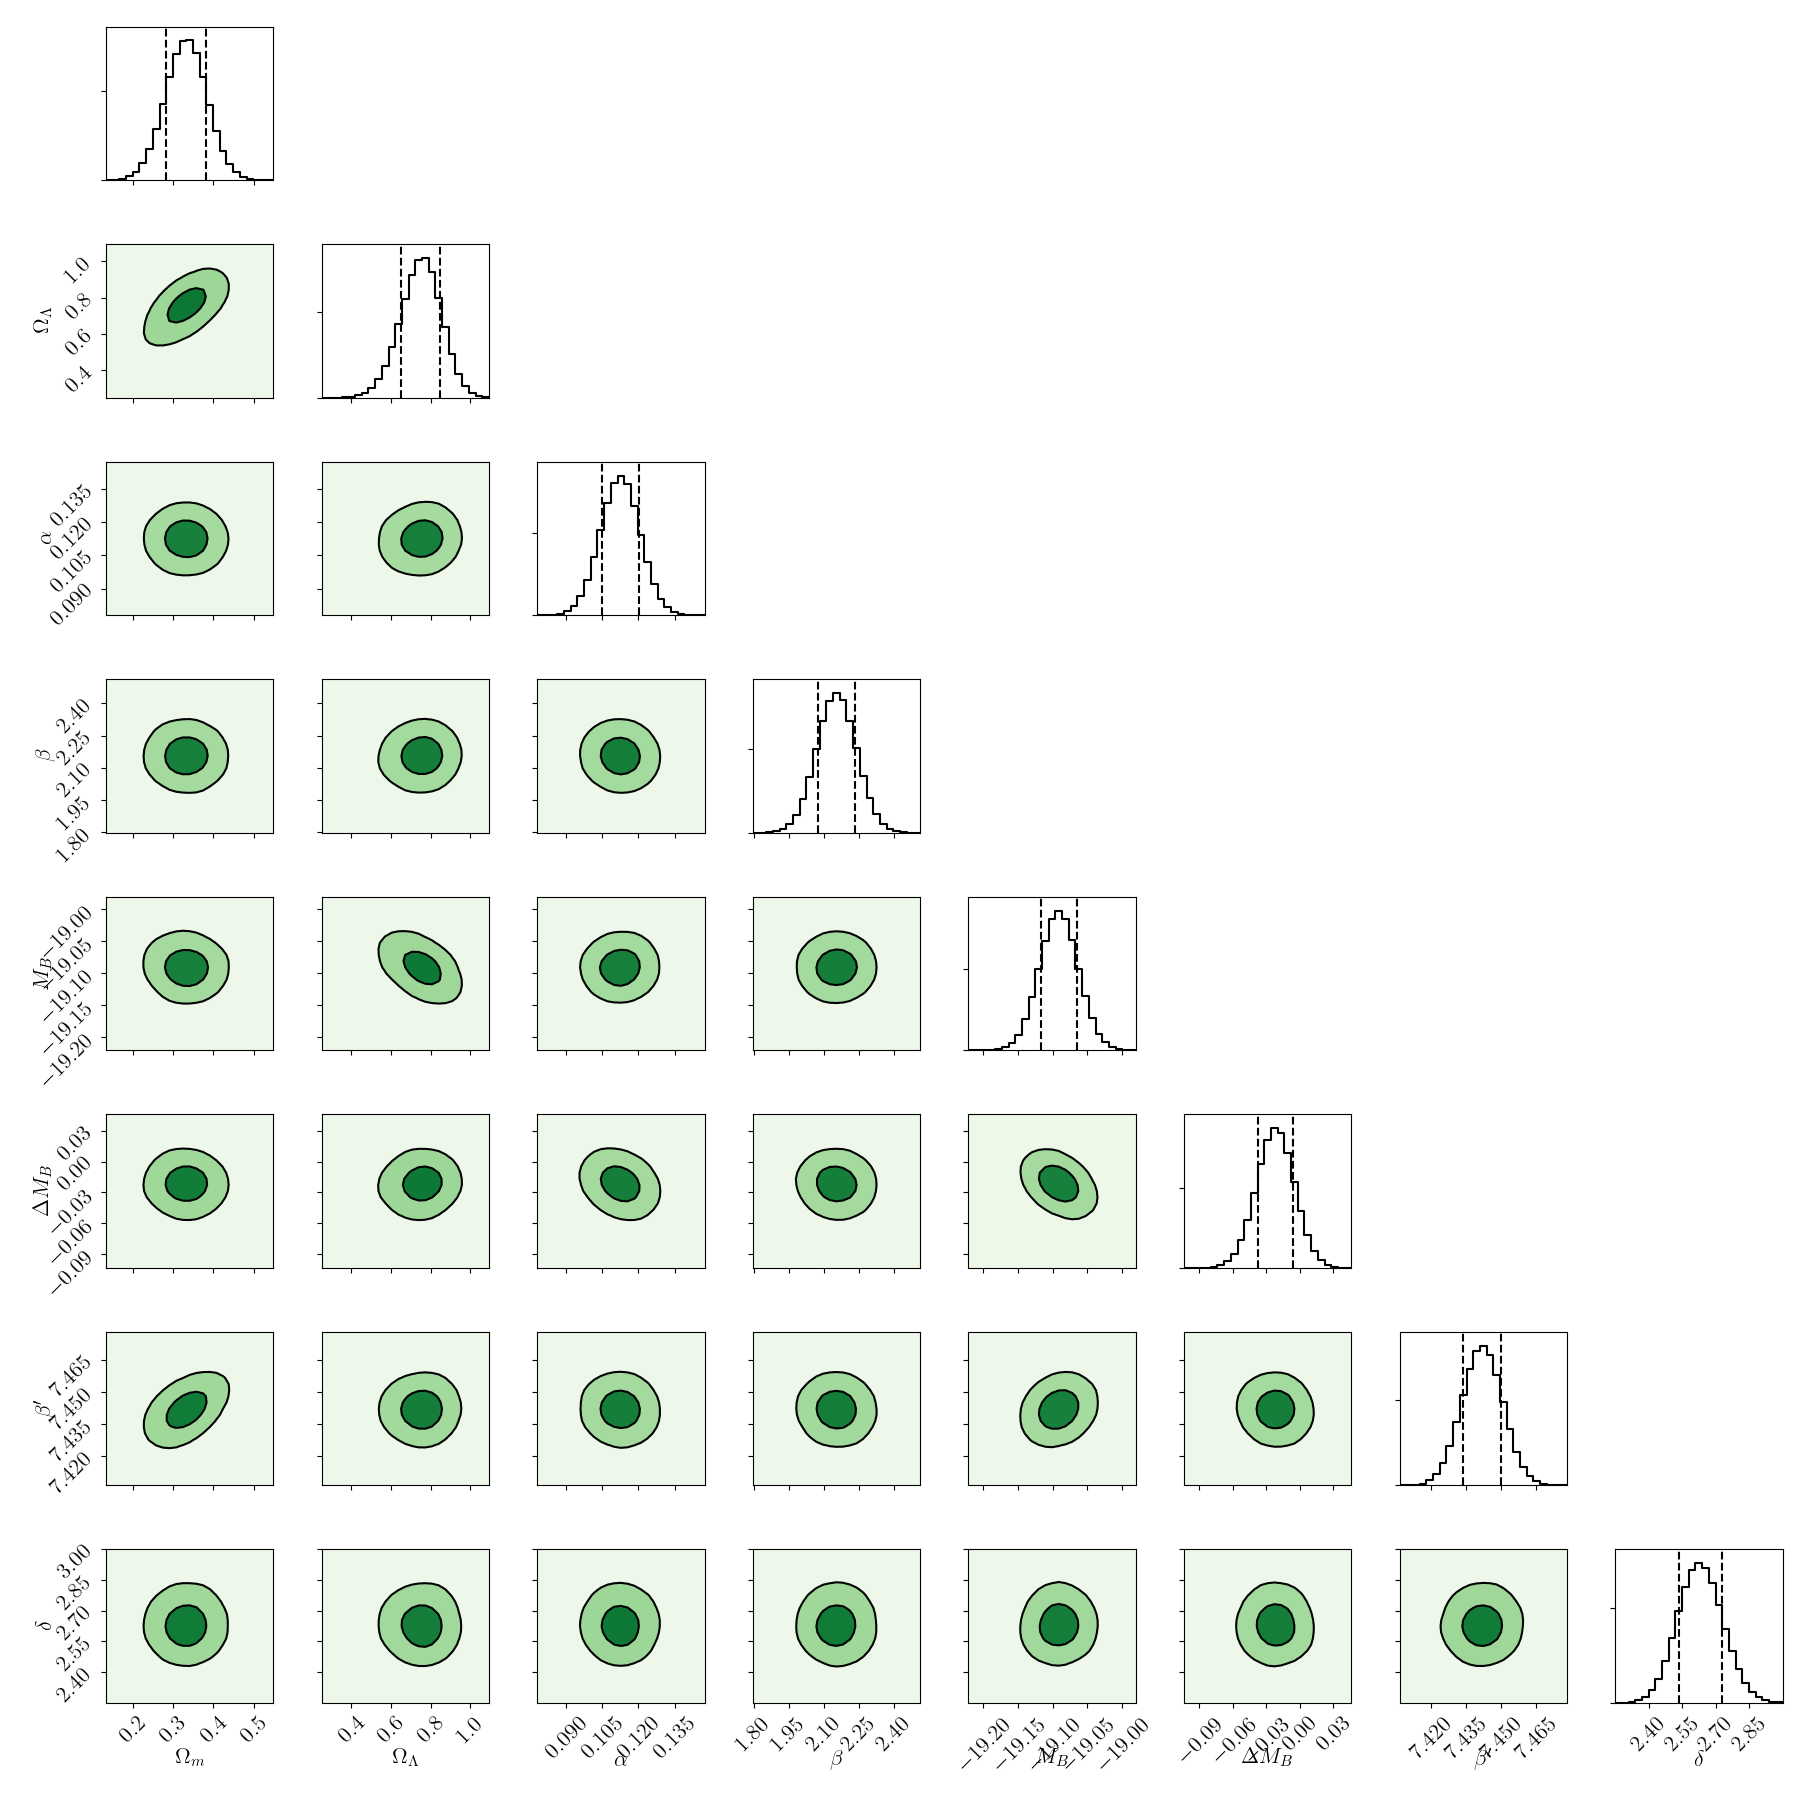

In [14]:
LCDM_samples = LCDM_sampler.get_chain()[Nmin:, :, :].reshape((-1, ndim))

meanLCDM = np.mean(LCDM_samples, axis=0)
stdLCDM = np.var(LCDM_samples, axis=0)
maxLCDM=[]
for i in range(len(meanLCDM)):
    likelihood = np.histogram(LCDM_samples.T[i], bins=50)
    i_max=np.argmax(likelihood[0])
    max_val = (likelihood[1][i_max]+likelihood[1][i_max+1])/2
    maxLCDM.append(max_val)


fig = corner(LCDM_samples, quantiles=(.16,.84),  levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)),
             labels=labs, smooth=True, smooth1d=True, bins=25, plot_datapoints=False, fill_contours=True, contourf_kwargs=dict(colors=None, cmap='Greens'))#,
# #              truths=maxLCDM)

plt.tight_layout()
plt.savefig('plots/posterior_LCDM.pdf')

## Visualize the results

In [15]:
v = np.percentile(LCDM_samples,[16, 50, 84], axis = 0)
v = np.asarray([v[1], v[2]-v[1],v[1]-v[0]]).T

omegam, stdmp, stdmm = v[0]
omegac, stdcp, stdcm = v[1]

#model
z = SNdata.get_data().T[0]
best_fit_cosmo_LCDM = cosmology(maxLCDM[1],Omega_r_preset,maxLCDM[2])

<IPython.core.display.Javascript object>


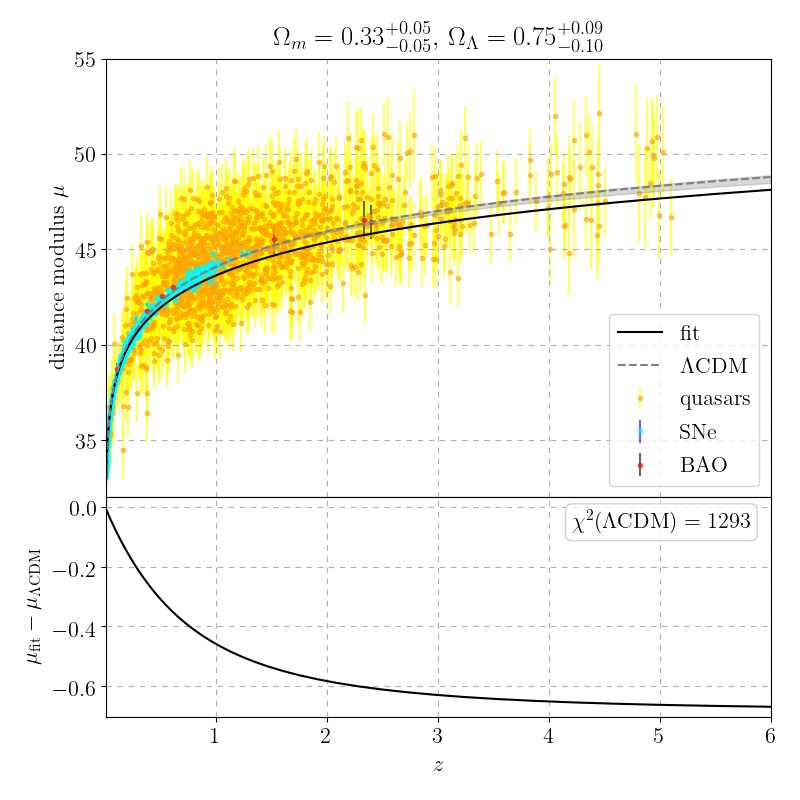

In [16]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 1)
gs.update(hspace=0)


ax1 = plt.subplot(gs[0:2, 0])
ax1.set_title('$\Omega_m = {%1.2f}^{+%1.2f}_{-%1.2f},\, \Omega_\Lambda = {%1.2f}^{+%1.2f}_{-%1.2f}$' % (omegam, stdmp,stdmm, omegac, stdcp,stdcm))#, stdkm, stdkp))

ax1.errorbar(Qdata.distance_modulus().T[0], Qdata.distance_modulus().T[1], yerr=Qdata.delta_distance_modulus(), linestyle='none', marker='o', color='orange', ecolor='yellow', markersize=3, alpha=0.6, zorder=-1, label=r'quasars')
ax1.errorbar(SNdata.distance_modulus().T[0], SNdata.distance_modulus().T[1], yerr=np.diag(SNdata.delta_distance_modulus()), linestyle='none', marker='o', color='cyan', ecolor='blue', markersize=3, alpha=0.6, zorder=-1, label=r'SNe')
ax1.errorbar(BAOdata.distance_modulus(cosmology(Omega_m_preset, Omega_r_preset, Omega_c_preset)).T[0], BAOdata.distance_modulus(cosmology(Omega_m_preset, Omega_r_preset, Omega_c_preset)).T[1], yerr=BAOdata.delta_distance_modulus(cosmology(Omega_m_preset, Omega_r_preset, Omega_c_preset)), linestyle='none', marker='o', color='red', ecolor='black', markersize=3, alpha=0.6, zorder=-1, label=r'BAO')



zPlot = np.logspace(-3,np.log10(6),100)
ax1.plot(zPlot, best_fit_cosmo_LCDM.distance_modulus(zPlot), c='k', label=r'fit')
ax1.fill_between(zPlot, cosmology(omegam+stdmp,Omega_r_preset,omegac+stdcp).distance_modulus(zPlot), cosmology(omegam-stdmm,Omega_r_preset,omegac-stdcm).distance_modulus(zPlot), color='gray', alpha=0.3)
ax1.plot(zPlot, cosmology(Omega_m_preset, Omega_r_preset, Omega_c_preset).distance_modulus(zPlot), ls = '--', c='gray', label=r'$\Lambda$CDM')

ax1.set_xlim(0.01,6)
ax1.set_ylim(32,55)


ax1.set_ylabel(r'distance modulus $\mu$')
ax1.set_xticklabels([])

ax1.grid('--', dashes=(5,5))
ax1.legend()


ax2 = plt.subplot(gs[2, 0])

ax2.plot(zPlot, best_fit_cosmo_LCDM.distance_modulus(zPlot) - cosmology(Omega_m_preset, Omega_r_preset, Omega_c_preset).distance_modulus(zPlot), 'k')

# ax2.set_xscale('log')
ax2.set_xlim(0.01,6)

ax2.text(0.97, .94, r'$\chi^2(\Lambda\mathrm{CDM}) = %1.0f$' % (-2*lnlike(maxLCDM,SNdata,Qdata,BAOdata)), ha='right', va='top', transform=ax2.transAxes, bbox=dict(facecolor=(1,1,1,.8), edgecolor='lightgray', boxstyle='round'))


ax2.grid('--', dashes=(5,5))
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\mu_\mathrm{fit} - \mu_{\Lambda\mathrm{CDM}}$')

plt.tight_layout()
plt.savefig('plots/Hubble_LCDM.pdf')
plt.show()

# Load $w\Lambda$LCDM data

In [ ]:
wLCDM_sampler = HDFBackend('results/wLCDM_500x1000.h5', read_only=True)

nsteps, nwalkers, ndim = wLCDM_sampler.get_chain().shape
labs = [r'$\Omega_m$', r'$\Omega_\Lambda$', r'$w$', r'$\alpha$', r'$\beta$', r'$M_B$', r'$\Delta M_B$', r'$\beta^\prime$', r'$\delta$']

## Check and visualise the convergence: $\tau_f / n_\mathrm{steps} < 1/30$

In [ ]:
Nmin = 0
while Nmin < nsteps and np.all(wLCDM_sampler.get_autocorr_time(tol=0,discard=Nmin)/(nsteps)*30 > 1):
    Nmin+=100
    
print('Nmin = {}'.format(Nmin))

In [ ]:
wLCDM_samples = wLCDM_sampler.get_chain()

f, ax = plt.subplots(len(wLCDM_samples.T), 1, figsize=(6,3*len(wLCDM_samples.T)))

for i in range(len(wLCDM_samples.T)):
    ax[i].plot(wLCDM_samples.T[i].T, lw=0.5)
    ax[i].plot([Nmin, Nmin], [min(wLCDM_samples.T[i].flatten()), max(wLCDM_samples.T[i].flatten())], c='k', lw=1.5)
    ax[i].text(Nmin, min(wLCDM_samples.T[i].flatten()), r'$n_\mathrm{min}$', rotation=90, ha='right')
    ax[i].set_ylabel(labs[i])
    ax[i].set_xlabel('iteration')
    
    
plt.tight_layout()
# plt.savefig('plots/convergence_wLCDM.pdf')
plt.show()

## Plot the 1$\sigma$ and 2$\sigma$ contours

In [ ]:
wLCDM_samples = wLCDM_sampler.get_chain()[Nmin:, :, :].reshape((-1, ndim))


meanwLCDM = np.mean(wLCDM_samples, axis=0)
stdwLCDM = np.var(wLCDM_samples, axis=0)
maxwLCDM=[]
for i in range(len(meanwLCDM)):
    likelihood = np.histogram(wLCDM_samples.T[i], bins=50)
    i_max=np.argmax(likelihood[0])
    max_val = (likelihood[1][i_max]+likelihood[1][i_max+1])/2
    maxwLCDM.append(max_val)


fig = corner(wLCDM_samples[:,:3], quantiles=(.16,.84),  levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)), range=[(0,.5), (.25,1.5), (-2.,-.3)],
             labels=labs, smooth=True, smooth1d=True, bins=25, plot_datapoints=False, fill_contours=True, contourf_kwargs=dict(colors=None, cmap='Greens'),
             truths=maxwLCDM[:3])

plt.tight_layout()
# plt.savefig('plots/posterior_wLCDM_1.pdf')

In [ ]:
fig = corner(wLCDM_samples[:,3:], quantiles=(.16,.84),  levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)),
             labels=labs[3:], smooth=True, smooth1d=True, bins=25, plot_datapoints=False, fill_contours=True, contourf_kwargs=dict(colors=None, cmap='Greens'))#,
#              truths=maxwLCDM[3:], truth_color='y')

plt.tight_layout()
# plt.savefig('plots/posterior_wLCDM_2.pdf')

## Visualize the results

In [ ]:
v = np.percentile(wLCDM_samples,[16, 50, 84], axis = 0)
v = np.asarray([v[1], v[2]-v[1],v[1]-v[0]]).T

omegam, stdmp, stdmm = v[0]
omegac, stdcp, stdcm = v[1]
w, wp, wm = v[2]

#model
z = SNdata.get_data().T[0]
best_fit_cosmo = cosmology(*maxwLCDM[:3])

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 1)
gs.update(hspace=0)


ax1 = plt.subplot(gs[0:2, 0])
ax1.set_title('$\Omega_m = {%1.2f}^{+%1.2f}_{-%1.2f},\, \Omega_\Lambda = {%1.2f}^{+%1.2f}_{-%1.2f},\, w = {%1.2f}^{+%1.2f}_{-%1.2f}$' % (omegam, stdmp,stdmm, omegac, stdcp,stdcm, w, wp, wm))#, stdkm, stdkp))

ax1.errorbar(Qdata.distance_modulus().T[0], Qdata.distance_modulus().T[1], yerr=Qdata.delta_distance_modulus(), linestyle='none', marker='o', color='orange', ecolor='yellow', markersize=3, alpha=0.6, zorder=-1, label=r'quasars')
ax1.errorbar(SNdata.distance_modulus().T[0], SNdata.distance_modulus().T[1], yerr=np.diag(SNdata.delta_distance_modulus()), linestyle='none', marker='o', color='cyan', ecolor='blue', markersize=3, alpha=0.6, zorder=-1, label=r'SNe')




zPlot = np.logspace(-3,np.log10(6),100)
ax1.plot(zPlot, best_fit_cosmo.distance_modulus(zPlot), c='k', label=r'fit')
ax1.fill_between(zPlot, cosmology(omegam+stdmp,omegac+stdcp, w + wp).distance_modulus(zPlot), cosmology(omegam-stdmm,omegac-stdcm, w - wm).distance_modulus(zPlot), color='gray', alpha=0.3)
ax1.plot(zPlot, cosmology(Omega_m, Omega_c).distance_modulus(zPlot), ls = '--', c='gray', label=r'$\Lambda$CDM')

ax1.set_xlim(0.01,6)
ax1.set_ylim(32,55)


ax1.set_ylabel(r'distance modulus $\mu$')
ax1.set_xticklabels([])

ax1.grid('--', dashes=(5,5))
ax1.legend()


ax2 = plt.subplot(gs[2, 0])

ax2.plot(zPlot, best_fit_cosmo.distance_modulus(zPlot) - cosmology(Omega_m, Omega_c).distance_modulus(zPlot), 'k')

# ax2.set_xscale('log')
ax2.set_xlim(0.01,6)

ax2.text(0.97, .94, r'$\chi^2(w\Lambda\mathrm{CDM}) = %1.0f$' % (-2*lnlike(maxwLCDM,SNdata,Qdata)), ha='right', va='top', transform=ax2.transAxes, bbox=dict(facecolor=(1,1,1,.8), edgecolor='lightgray', boxstyle='round'))


ax2.grid('--', dashes=(5,5))
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\mu_\mathrm{fit} - \mu_{\Lambda\mathrm{CDM}}$')

plt.tight_layout()
# plt.savefig('plots/Hubble_wLCDM.pdf')
plt.show()

# Conformal Gravity

## Rotation curve data

In [ ]:
log10gamma0, log10kappa0 = -6, -4
RC_data = RCdata([10**log10gamma0, 10**log10kappa0])

In [ ]:
#likelihood function
def lnlike(theta, SNdata, Qdata, RCdata):
    Omegam, log10gamma0, log10kappa, a, b, MB, delta_Mhost, beta_prime, s = theta
    gamma0 = 10**log10gamma0
    kappa = 10**log10kappa
    
    Omegak =  (gamma0)**2 / 2 *cosmology.cLight**2/(cosmology.H0)**2
    Omegac = 1-Omegam-Omegak
    
    LCDM = cosmology(Omegam, Omegac)
    SNdata.set_param(np.array([a,b,MB, delta_Mhost]))
    Qdata.set_param(np.array([beta_prime, s]))
    
    log_prob = LCDM.log_likelihood(SNdata.distance_modulus(), SNdata.delta_distance_modulus())
    log_prob += LCDM.log_likelihood(Qdata.distance_modulus(), Qdata.delta_distance_modulus())
    
    if np.isnan(log_prob):
        return -np.inf

    RCdata.set_param([gamma0, kappa])
    RCdata.fit()
    log_prob += RCdata.get_loglike()


    return log_prob


def lnprior(theta):
    Omegam, log10gamma0, log10kappa, a, b, MB, delta_Mhost, beta_prime, s = theta
    gamma0 = 10**log10gamma0
    kappa = 10**log10kappa
    Omegak =  (gamma0)**2 / 2 *cosmology.cLight**2/(cosmology.H0)**2 # * kpc**2 * 10**6
    Omegac = 1-Omegam-Omegak

    if -.1 < Omegam < 0 and 0 < Omegak < 1.0 and -5 <= a < 5 and -10 < b < 10 and -50 < MB < 0 and -0.5 < delta_Mhost < 0.5 and 0 < s <= 3:
        return 0.0
    return -np.inf

def lnprob(theta, SNdata, Qdata, RCdata):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, SNdata, Qdata, RCdata)


## Load Conformal Gravity data

In [ ]:
CG_sampler = HDFBackend('results/CG_500x1000.h5', read_only=True)

nsteps, nwalkers, ndim = CG_sampler.get_chain().shape
labs=[r'$\Omega_m$', r'$(\gamma_0/\mathrm{Mpc}^{-1})$', r'$(\kappa/\mathrm{Mpc}^{-2})$',r'$\alpha$', r'$\beta$', r'$M_B$', r'$\Delta M_B$', r'$\beta^\prime$', r'$\delta$']

In [ ]:
CG_samples = CG_sampler.get_chain()

f, ax = plt.subplots(len(CG_samples.T), 1, figsize=(6,3*len(CG_samples.T)))

for i in range(len(CG_samples.T)):
    ax[i].plot(CG_samples.T[i].T, lw=0.5)
#     ax[i].plot([Nmin, Nmin], [min(CG_samples.T[i].flatten()), max(CG_samples.T[i].flatten())], c='k', lw=1.5)
#     ax[i].text(Nmin, min(CG_samples.T[i].flatten()), r'$n_\mathrm{min}$', rotation=90, ha='right')
    ax[i].set_ylabel(labs[i])
    ax[i].set_xlabel('iteration')
    
    
plt.tight_layout()
# plt.savefig('plots/convergence_CG.pdf')
plt.show()

In [ ]:
CG_samples = CG_sampler.get_chain()[200:, :, :].reshape((-1, ndim))

# CG_samples[:,1] = (10**CG_samples[:,1])**2 / 2 *cosmology.cLight**2/(cosmology.H0)**2
# CG_samples[:,2] = 10**CG_samples[:,2]


meanCG = np.mean(CG_samples, axis=0)
stdCG = np.var(CG_samples, axis=0)
maxCG=[]
for i in range(len(meanCG)):
    likelihood = np.histogram(CG_samples.T[i], bins=50)
    i_max=np.argmax(likelihood[0])
    max_val = (likelihood[1][i_max]+likelihood[1][i_max+1])/2
    maxCG.append(max_val)


fig = corner(CG_samples[:,:3], quantiles=(.16,.84),  levels=(1-np.exp(-0.5),1-np.exp(-0.5*4)), range=[(-.05,.1), (-20,0), (-15,0)],
             labels=labs, smooth=True, smooth1d=True, bins=50, plot_datapoints=False, fill_contours=True, contourf_kwargs=dict(colors=None, cmap='Greens'),
             truths=maxCG[:3])

plt.tight_layout()
# plt.savefig('plots/posterior_CG_1.pdf')

## Visualize the results

In [ ]:
v = np.percentile(CG_samples,[16, 50, 84], axis = 0)
v = np.asarray([v[1], v[2]-v[1],v[1]-v[0]]).T



gamma0 = 10**log10gamma0
kappa = 10**log10kappa
Omegak =  (gamma0)**2 / 2 *cosmology.cLight**2/(cosmology.H0)**2 # * kpc**2 * 10**6
Omegac = 1-Omegam-Omegak

omegam, stdmp, stdmm = v[0]
omegac, stdcp, stdcm = v[1]
w, wp, wm = v[2]

#model
z = SNdata.get_data().T[0]
best_fit_cosmo = cosmology(*maxCG[:3])

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 1)
gs.update(hspace=0)


ax1 = plt.subplot(gs[0:2, 0])
ax1.set_title('$\Omega_m = {%1.2f}^{+%1.2f}_{-%1.2f},\, \Omega_\Lambda = {%1.2f}^{+%1.2f}_{-%1.2f},\, w = {%1.2f}^{+%1.2f}_{-%1.2f}$' % (omegam, stdmp,stdmm, omegac, stdcp,stdcm, w, wp, wm))#, stdkm, stdkp))

ax1.errorbar(Qdata.distance_modulus().T[0], Qdata.distance_modulus().T[1], yerr=Qdata.delta_distance_modulus(), linestyle='none', marker='o', color='orange', ecolor='yellow', markersize=3, alpha=0.6, zorder=-1, label=r'quasars')
ax1.errorbar(SNdata.distance_modulus().T[0], SNdata.distance_modulus().T[1], yerr=np.diag(SNdata.delta_distance_modulus()), linestyle='none', marker='o', color='cyan', ecolor='blue', markersize=3, alpha=0.6, zorder=-1, label=r'SNe')




zPlot = np.logspace(-3,np.log10(6),100)
ax1.plot(zPlot, best_fit_cosmo.distance_modulus(zPlot), c='k', label=r'fit')
ax1.fill_between(zPlot, cosmology(omegam+stdmp,omegac+stdcp, w + wp).distance_modulus(zPlot), cosmology(omegam-stdmm,omegac-stdcm, w - wm).distance_modulus(zPlot), color='gray', alpha=0.3)
ax1.plot(zPlot, cosmology(Omega_m, Omega_c).distance_modulus(zPlot), ls = '--', c='gray', label=r'$\Lambda$CDM')

ax1.set_xlim(0.01,6)
ax1.set_ylim(32,55)


ax1.set_ylabel(r'distance modulus $\mu$')
ax1.set_xticklabels([])

ax1.grid('--', dashes=(5,5))
ax1.legend()


ax2 = plt.subplot(gs[2, 0])

ax2.plot(zPlot, best_fit_cosmo.distance_modulus(zPlot) - cosmology(Omega_m, Omega_c).distance_modulus(zPlot), 'k')

# ax2.set_xscale('log')
ax2.set_xlim(0.01,6)

ax2.text(0.97, .94, r'$\chi^2(w\Lambda\mathrm{CDM}) = %1.0f$' % (-2*lnlike(maxCG,SNdata,Qdata)), ha='right', va='top', transform=ax2.transAxes, bbox=dict(facecolor=(1,1,1,.8), edgecolor='lightgray', boxstyle='round'))


ax2.grid('--', dashes=(5,5))
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\mu_\mathrm{fit} - \mu_{\Lambda\mathrm{CDM}}$')

plt.tight_layout()
# plt.savefig('plots/Hubble_CG.pdf')
plt.show()